# Processing scripts for generating figures for Dafne paper

## Processing log file

In [5]:
import os
from typing import Iterable
import re

DELETE_NONANON_FILES = False

def find_elements_pattern(string_list: Iterable[str], pattern: str):
    return [ s for s in string_list if re.match(pattern, s) is not None]

### Anonymization

In [8]:
def anonymize_line(line: str):
    pattern = 'accessed by \S+'
    rep = 'accessed by XXXXXXX'
    line = re.sub(pattern, rep, line)
    pattern2 = 'Log message from \S+'
    rep2 = 'Log message from XXXXXXX'
    line = re.sub(pattern2, rep2, line)
    pattern3 = r'([0-9]+)_\S+.model'
    rep3 = r'\1_XXXXXXX.model'
    line = re.sub(pattern3, rep3, line)
    return line
    

def anonymize_file(filename: str):
    out_filename = filename[:-3] + 'anon.txt'
    with open(filename, 'r') as input_file:
        with open(out_filename, 'w') as output_file:
            for line in input_file:
                output_file.write(anonymize_line(line))

files = os.listdir()
nonanon_log_files = find_elements_pattern(files, 'log.*(?<!anon)\.txt')
for file in nonanon_log_files:
    anonymize_file(file)
    if DELETE_NONANON_FILES:
        os.unlink(file)
    print('Anonymized', file)


Anonymized log_20220831_orig.txt


### Read in anonymized file

In [6]:
import os
from dateutil.parser import parse
import pandas as pd

files = os.listdir()
anon_log_files = find_elements_pattern(files, 'log.*anon\.txt')
anon_log_file = anon_log_files[0]
print('Reading from', anon_log_file)

def split_log_line(line: str):
    date_part = line[:27]
    text_part = line[27:].strip()
    date = parse(date_part)
    return (date, text_part)

with open(anon_log_file,'r') as f:
    log_lines = [ split_log_line(line) for line in f ]
    
log_frame = pd.DataFrame(log_lines, columns = ['DateTime', 'Message'])
log_frame = log_frame.set_index('DateTime')


Reading from log_20220831_orig.anon.txt


### Filter dates and messages

In [49]:
from datetime import datetime

date_start = datetime(2021,7,1)

sub_frame = log_frame.loc[date_start:]

In [50]:
# Extract dice scores

def extract_dice(line):
    m = re.search('client dice ([0-9.]+)', line)
    if not m: return None
    return float(m.group(1))

dice_messages_mask = sub_frame['Message'].str.contains('client dice')
dice_messages_frame = sub_frame[dice_messages_mask]
dice_scores = dice_messages_frame['Message'].apply(extract_dice)
dice_scores = dice_scores[dice_scores > 0]
dice_scores.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 256 entries, 2021-07-05 08:43:32.036859 to 2022-08-30 14:34:38.191543
Series name: Message
Non-Null Count  Dtype  
--------------  -----  
256 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


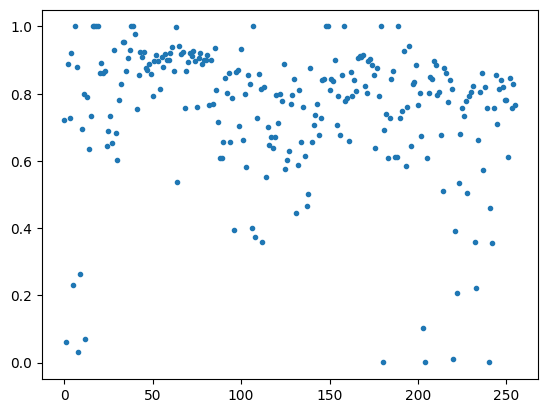

In [51]:
import matplotlib.pyplot as plt
import numpy as np
dice_scores_notime = np.array(list(dice_scores))
plt.plot(dice_scores_notime, '.')